In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings


In [ ]:

# Load the uploaded CSV file
file_path = r"e:\Nieuw dataset\Joined trends\joined_trend_sales_All.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()



,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,BenzineEuro95_1_last,BenzineEuro95_1_min,BenzineEuro95_1_max,BenzineEuro95_1_mean,Diesel_2_first,Diesel_2_last,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen
0,2007/01,0,1,0,0,20.0,37.0,9.0,8.0,1.318,1.301,1.283,1.326,1.303032,0.992,0.969,0.955,0.993,0.970000,31
1,2007/02,0,0,0,0,20.0,37.0,9.0,8.0,1.307,1.362,1.307,1.362,1.325357,0.977,1.003,0.977,1.003,0.990000,39
2,2007/03,0,0,0,0,20.0,37.0,9.0,8.0,1.365,1.416,1.361,1.416,1.379032,1.003,1.038,0.995,1.038,1.006323,123
3,2007/04,0,0,0,0,20.0,37.0,9.0,8.0,1.414,1.450,1.410,1.451,1.426500,1.036,1.026,1.019,1.039,1.030600,62
4,2007/05,0,2,0,0,18.0,32.0,9.0,7.4,1.452,1.463,1.449,1.483,1.466516,1.028,1.037,1.021,1.047,1.032323,84


Reformat Time Column

In [6]:
# Convert 'Periode' to datetime format
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")

# Sort by time just in case
df = df.sort_values("Periode").reset_index(drop=True)

# Show the first 3 rows to confirm
df[["Periode", "Totaal_verkochte_wegvoertuigen"]].head(3)


,Periode,Totaal_verkochte_wegvoertuigen
0,2007-01-01,31
1,2007-02-01,39
2,2007-03-01,123


 Step 2: Sort by Time
Ensure the dataset is chronologically ordered.

🔹 Step 3: Create Lag Features
Use previous months’ target values to create lag_1, lag_2, …, which help the model recognize trends.

🔹 Step 4: Optional Rolling Features
Create moving averages or other window statistics to capture trends (e.g., 3-month mean).

🔹 Step 5: Encode Date Features
Extract month, quarter, year, etc., as new columns to help the model detect seasonality.

🔹 Step 6: Train-Test Split
Use a walk-forward or time-based split (not random) to evaluate models.

In [17]:

# Create 6 lag features for EV sales (Brownlee, Chapter 3, p. 42–44)
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)

# Drop rows with missing values due to lagging
df_lagged = df.dropna().reset_index(drop=True)


display(df_lagged.head(3))

print(df_lagged.columns.tolist())

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,Diesel_2_min,Diesel_2_max,Diesel_2_mean,Totaal_verkochte_wegvoertuigen,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6
0,2007-07-01,0,1,0,0,14.0,22.0,9.0,6.2,1.451,...,1.057,1.069,1.063484,124,112.0,84.0,62.0,123.0,39.0,31.0
1,2007-08-01,0,1,0,0,12.0,17.0,9.0,5.6,1.415,...,1.045,1.068,1.052387,96,124.0,112.0,84.0,62.0,123.0,39.0
2,2007-09-01,0,1,0,0,10.0,12.0,9.0,5.0,1.422,...,1.056,1.094,1.081133,120,96.0,124.0,112.0,84.0,62.0,123.0


['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Bijtellingspercentage', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'Totaal_verkochte_wegvoertuigen', 'TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6']


In [31]:
# Encode date features: extract year, month, and quarter from 'Periode'
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter

display(df_lagged)

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtellingspercentage,Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,Totaal_verkochte_wegvoertuigen,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter
0,2007-07-01,0,1,0,0,14.00,22.0,9.00,6.20,1.451,...,124,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3
1,2007-08-01,0,1,0,0,12.00,17.0,9.00,5.60,1.415,...,96,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3
2,2007-09-01,0,1,0,0,10.00,12.0,9.00,5.00,1.422,...,120,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3
3,2007-10-01,0,1,0,0,5.50,5.0,6.00,1.50,1.413,...,77,120.0,96.0,124.0,112.0,84.0,62.0,2007,10,4
4,2007-11-01,0,1,0,0,1.00,-2.0,3.00,-2.00,1.456,...,170,77.0,120.0,96.0,124.0,112.0,84.0,2007,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2024-09-01,57,52,59,16,-21.00,-37.0,-11.00,-29.00,1.912,...,28820,23683.0,25370.0,27731.0,26607.0,25326.0,29193.0,2024,9,3
207,2024-10-01,79,50,63,16,-23.00,-40.0,-11.50,-28.50,1.860,...,30491,28820.0,23683.0,25370.0,27731.0,26607.0,25326.0,2024,10,4
208,2024-11-01,68,48,46,16,-25.00,-43.0,-12.00,-28.00,1.914,...,32623,30491.0,28820.0,23683.0,25370.0,27731.0,26607.0,2024,11,4
209,2024-12-01,69,46,60,16,-26.00,-45.0,-13.00,-27.00,1.953,...,39594,32623.0,30491.0,28820.0,23683.0,25370.0,27731.0,2024,12,4


In [35]:
print(df_lagged.columns.tolist())

['Periode', 'thuis opladen', 'elektrische auto', 'hybride elektrisch', 'Bijtellingspercentage', 'Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'Totaal_verkochte_wegvoertuigen', 'TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']


In [9]:
# Walk-forward split: start with 80% as initial train, then predict one by one
drop_cols = ['Periode', 'Totaal_verkochte_wegvoertuigen']
target_col = 'Totaal_verkochte_wegvoertuigen'
feature_cols = [col for col in df_lagged.columns if col not in drop_cols]

initial_train_size = int(len(df_lagged) * 0.8)
walkforward_predictions = []
walkforward_actuals = []

X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    
    walkforward_predictions.append(y_pred)
    walkforward_actuals.append(y_test)

print(f"Walk-forward predictions: {len(walkforward_predictions)} points")


Walk-forward predictions: 43 points


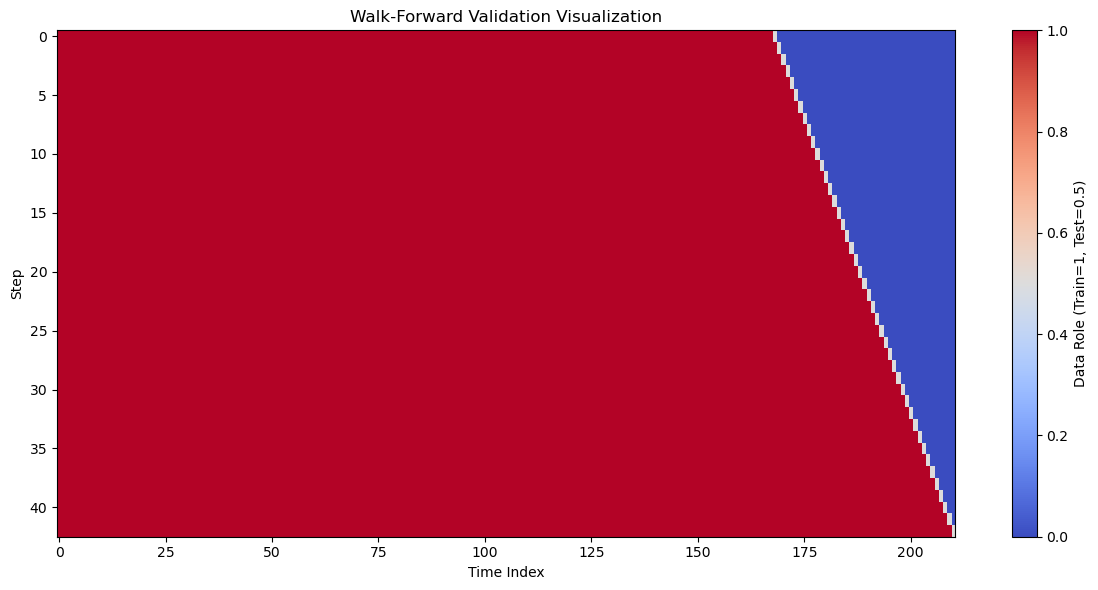

In [32]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = len(df_lagged)
initial_train_size = int(n_samples * 0.8)
n_steps = n_samples - initial_train_size

visual_matrix = np.zeros((n_steps, n_samples))

for i in range(n_steps):
    train_end = initial_train_size + i
    visual_matrix[i, :train_end] = 1  # Train = 1
    visual_matrix[i, train_end] = 0.5  # Test point = 0.5

plt.figure(figsize=(12, 6))
plt.imshow(visual_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.title("Walk-Forward Validation Visualization")
plt.xlabel("Time Index")
plt.ylabel("Step")
plt.colorbar(label="Data Role (Train=1, Test=0.5)")
plt.tight_layout()
plt.show()


In [ ]:
# "Walk-forward predictions: 43 points" betekent dat er 43 voorspellingen zijn gedaan met de walk-forward validatie.
# Dit houdt in dat het model telkens één maand vooruit voorspelt, op basis van alle voorgaande data.
# In dit geval zijn er dus 43 maanden in de testperiode waarvoor een voorspelling is gemaakt.


Er zijn 43 voorspellingen gedaan met walk-forward validatie.


📊 Evaluation Metrics (Walk-Forward)
MAE:  4042.01
RMSE: 6581.70
R²:   -0.0884
MAPE: 32.69%


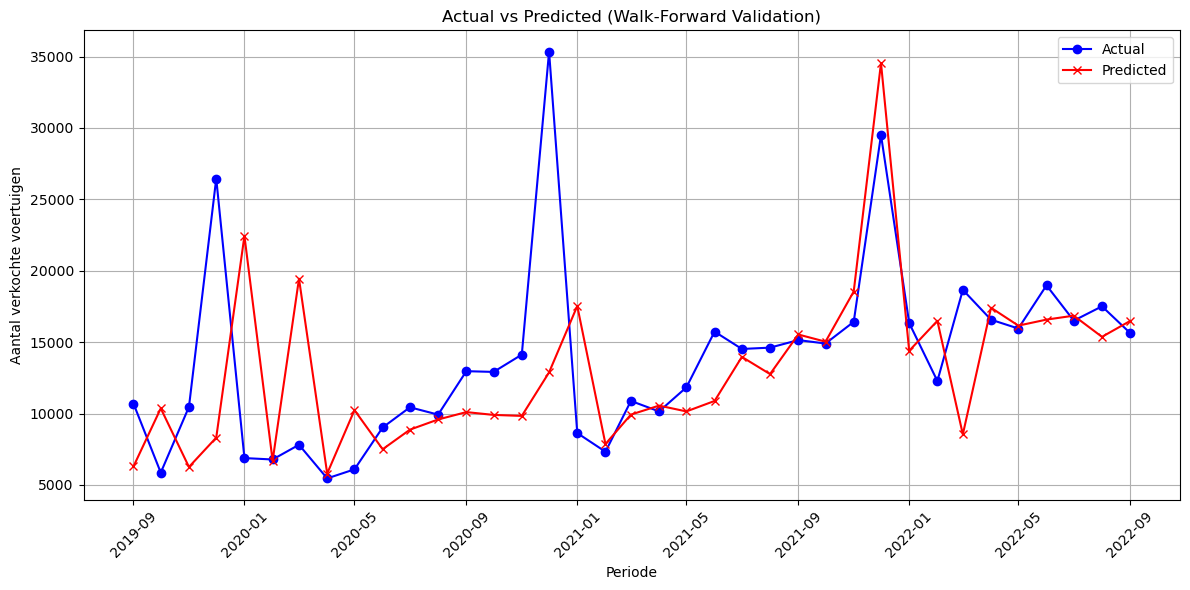

In [70]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

initial_train_size = int(len(df_lagged) * 0.8)

predictions = []
actuals = []

for i in range(initial_train_size, len(X)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test.reshape(1, -1))[0]

    predictions.append(y_pred)
    actuals.append(y_test)

# Convert to numpy for metric calculations
predictions = np.array(predictions)
actuals = np.array(actuals)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print(f"📊 Evaluation Metrics (Walk-Forward)")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

import matplotlib.pyplot as plt

# Create timeline for the predictions
prediction_dates = df_lagged["Periode"].iloc[initial_train_size:].values

plt.figure(figsize=(12, 6))
plt.plot(prediction_dates, actuals, label="Actual", marker='o', color='blue')
plt.plot(prediction_dates, predictions, label="Predicted", marker='x', color='red')

plt.title("Actual vs Predicted (Walk-Forward Validation)")
plt.xlabel("Periode")
plt.ylabel("Aantal verkochte voertuigen")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [71]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Use the already defined X_train, y_train, X_test, y_test arrays

# Train model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test.reshape(1, -1))

# Evaluation
mae = mean_absolute_error([y_test], y_pred)
rmse = np.sqrt(mean_squared_error([y_test], y_pred))
r2 = r2_score([y_test], y_pred)
mape = np.mean(np.abs((y_test - y_pred[0]) / y_test)) * 100

print(f"📊 Evaluation Metrics (Hold-Out)")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")



📊 Evaluation Metrics (Hold-Out)
MAE:  847.32
RMSE: 847.32
R²:   nan
MAPE: 5.42%


c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
from xgboost import XGBRegressor  # Import the XGBoost regressor class
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Import regression metrics
import numpy as np  # Import numpy for numerical operations
import pandas as pd  # Import pandas for data manipulation

# Extract data
X = df_lagged[feature_cols].values  # Get feature matrix as numpy array from selected columns
y = df_lagged[target_col].values    # Get target variable as numpy array

# Start walk-forward
initial_train_size = int(len(df_lagged) * 0.8)  # Use 80% of data as initial training set
predictions = []  # List to store predictions
actuals = []      # List to store actual target values

for i in range(initial_train_size, len(df_lagged)):  # Loop over each test point in the walk-forward period
    # Split up to i (train), predict i (test point)
    X_train, y_train = X[:i], y[:i]  # Use all data up to i as training set
    X_test, y_test = X[i], y[i]      # Use the i-th data point as test set
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)  # Create XGBoost regressor
    model.fit(X_train, y_train)  # Fit model on training data
    y_pred = model.predict(X_test.reshape(1, -1))[0]  # Predict for the test point and get scalar value
    
    predictions.append(y_pred)  # Store prediction
    actuals.append(y_test)      # Store actual value

# Evaluation
mae = mean_absolute_error(actuals, predictions)  # Compute Mean Absolute Error
rmse = np.sqrt(mean_squared_error(actuals, predictions))  # Compute Root Mean Squared Error
r2 = r2_score(actuals, predictions)  # Compute R-squared score
mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100  # Compute Mean Absolute Percentage Error

print("📈 Walk-Forward Validation Results")  # Print header
print(f"MAE:  {mae:.2f}")    # Print MAE
print(f"RMSE: {rmse:.2f}")   # Print RMSE
print(f"R²:   {r2:.4f}")     # Print R-squared
print(f"MAPE: {mape:.2f}%")  # Print MAPE


📈 Walk-Forward Validation Results
MAE:  3278.99
RMSE: 4486.29
R²:   0.4822
MAPE: 13.93%


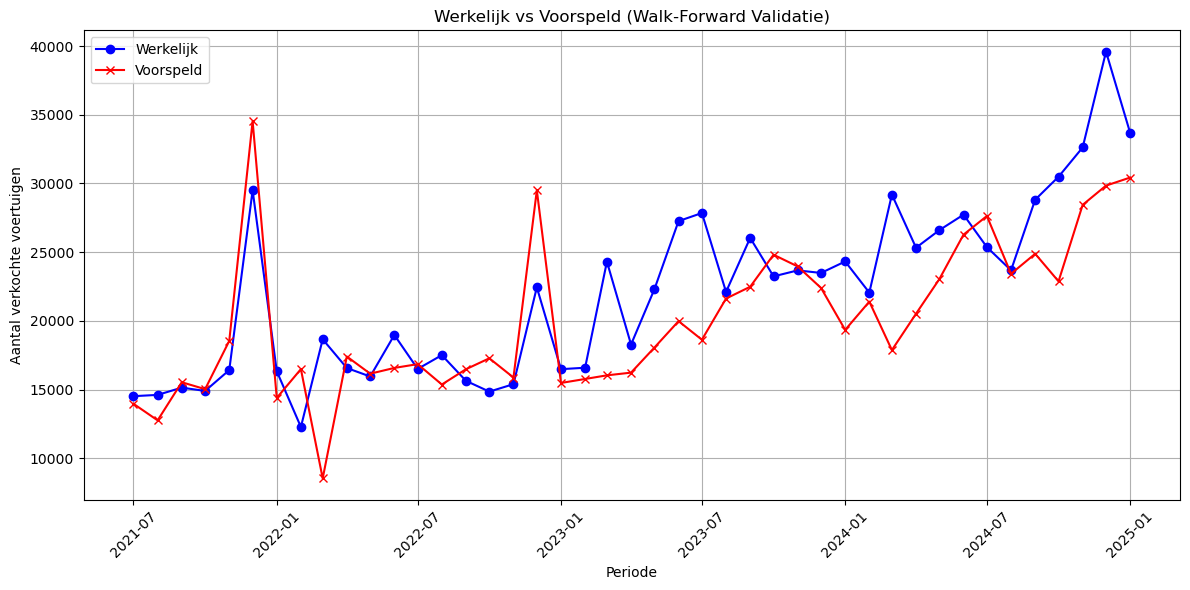

In [89]:
import matplotlib.pyplot as plt

# Create timeline for the predictions
start_index = initial_train_size
prediction_dates = df_lagged["Periode"].iloc[start_index:].values

plt.figure(figsize=(12, 6))
plt.plot(prediction_dates, actuals, label="Werkelijk", marker='o', color='blue')
plt.plot(prediction_dates, predictions, label="Voorspeld", marker='x', color='red')

plt.title("Werkelijk vs Voorspeld (Walk-Forward Validatie)")
plt.xlabel("Periode")
plt.ylabel("Aantal verkochte voertuigen")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


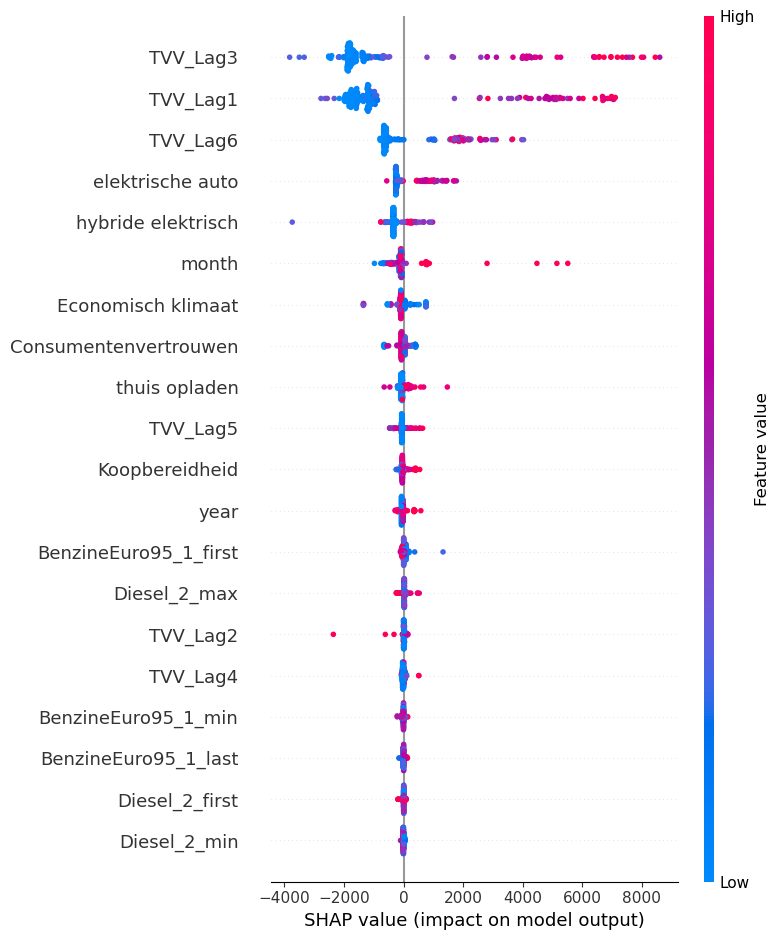

In [46]:
import shap

# Fit the model on the full training set for SHAP analysis
model.fit(df_lagged[feature_cols], df_lagged[target_col])

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(df_lagged[feature_cols])

# Plot summary of feature importance
shap.summary_plot(shap_values, df_lagged[feature_cols], feature_names=feature_cols)

📈 Walk-Forward Validation Results 
MAE:  3757.85
RMSE: 5741.22
R²:   0.1718
MAPE: 30.28%


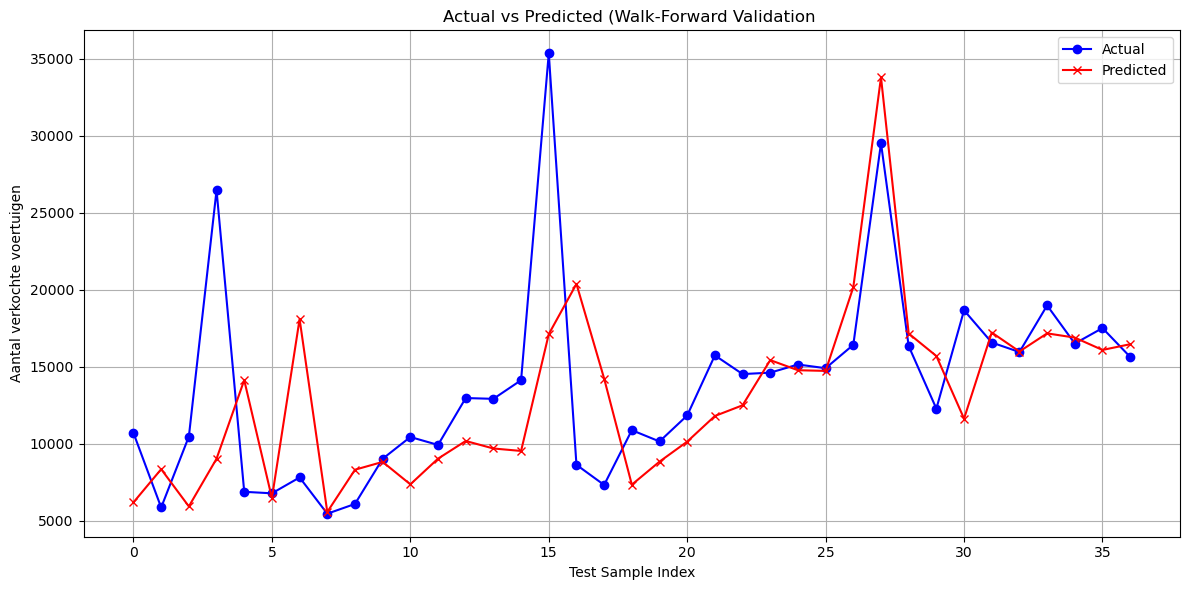

In [72]:

# Extract data
X = df_lagged[feature_cols].values
y = df_lagged[target_col].values

# Start walk-forward
initial_train_size = int(len(df_lagged) * 0.8)
predictions = []
actuals = []

for i in range(initial_train_size, len(df_lagged)):
    # Split up to i (train), predict i (test point)
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    # Define early stopping evaluation set from last 10 points of X_train
    if len(X_train) > 20:
        X_val_es = X_train[-10:]
        y_val_es = y_train[-10:]
    else:
        X_val_es = X_train
        y_val_es = y_train

    # Train with early stopping
    model = XGBRegressor(objective='reg:squarederror',
                         n_estimators=200,
                         learning_rate=0.1,
                         max_depth=5,
                         random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test.reshape(1, -1))[0]
    
    predictions.append(y_pred)
    actuals.append(y_test)

# Evaluation
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100

print("📈 Walk-Forward Validation Results ")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.2f}%")



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", marker='o', color='blue')
plt.plot(predictions, label="Predicted", marker='x', color='red')
plt.title("Actual vs Predicted (Walk-Forward Validation ")
plt.xlabel("Test Sample Index")
plt.ylabel("Aantal verkochte voertuigen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📉 Baseline (Lag Features Only) Walk-Forward Results
MAE:  5610.86
RMSE: 8405.66
R²:   -0.7753
MAPE: 46.10%


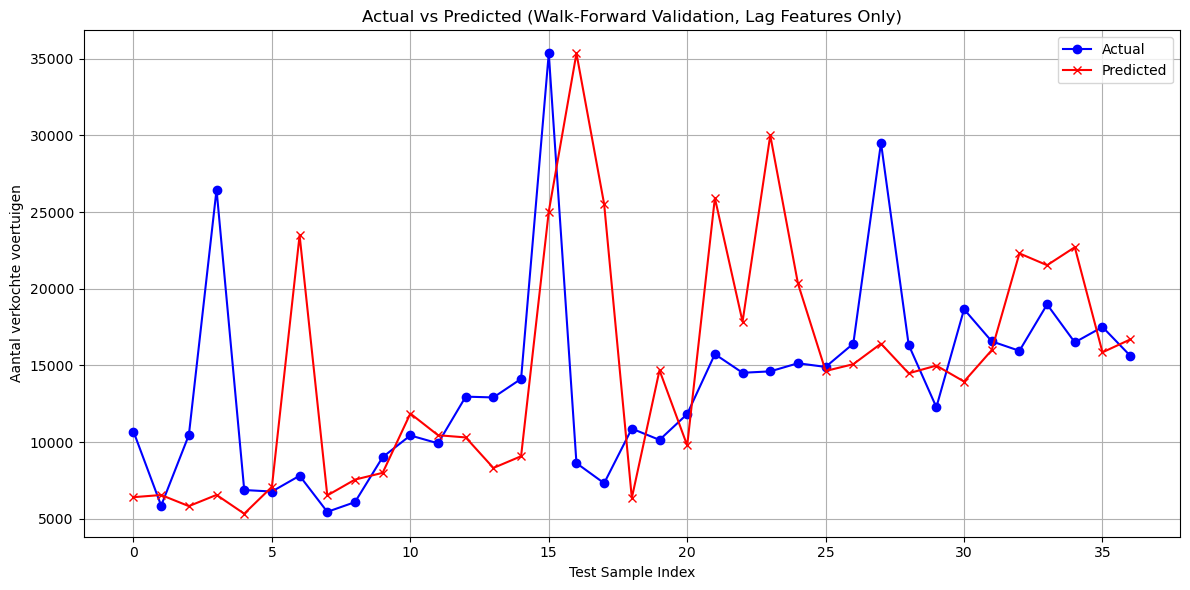

In [73]:

# Baseline XGBoost model using only lagged sales features
lag_features = [col for col in feature_cols if col.startswith("TVV_Lag")]

X_lag = df_lagged[lag_features].values
y_lag = df_lagged[target_col].values

# Walk-forward split as before
initial_train_size_lag = int(len(df_lagged) * 0.8)
predictions_lag = []
actuals_lag = []

for i in range(initial_train_size_lag, len(df_lagged)):
    X_train_lag, y_train_lag = X_lag[:i], y_lag[:i]
    X_test_lag, y_test_lag = X_lag[i], y_lag[i]
    
    model_lag = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model_lag.fit(X_train_lag, y_train_lag)
    y_pred_lag = model_lag.predict(X_test_lag.reshape(1, -1))[0]
    
    predictions_lag.append(y_pred_lag)
    actuals_lag.append(y_test_lag)

# Evaluation
mae_lag = mean_absolute_error(actuals_lag, predictions_lag)
rmse_lag = np.sqrt(mean_squared_error(actuals_lag, predictions_lag))
r2_lag = r2_score(actuals_lag, predictions_lag)
mape_lag = np.mean(np.abs((np.array(actuals_lag) - np.array(predictions_lag)) / np.array(actuals_lag))) * 100

print("📉 Baseline (Lag Features Only) Walk-Forward Results")
print(f"MAE:  {mae_lag:.2f}")
print(f"RMSE: {rmse_lag:.2f}")
print(f"R²:   {r2_lag:.4f}")
print(f"MAPE: {mape_lag:.2f}%")


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals_lag, label="Actual", marker='o', color='blue')
plt.plot(predictions_lag, label="Predicted", marker='x', color='red')
plt.title("Actual vs Predicted (Walk-Forward Validation, Lag Features Only)")
plt.xlabel("Test Sample Index")
plt.ylabel("Aantal verkochte voertuigen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


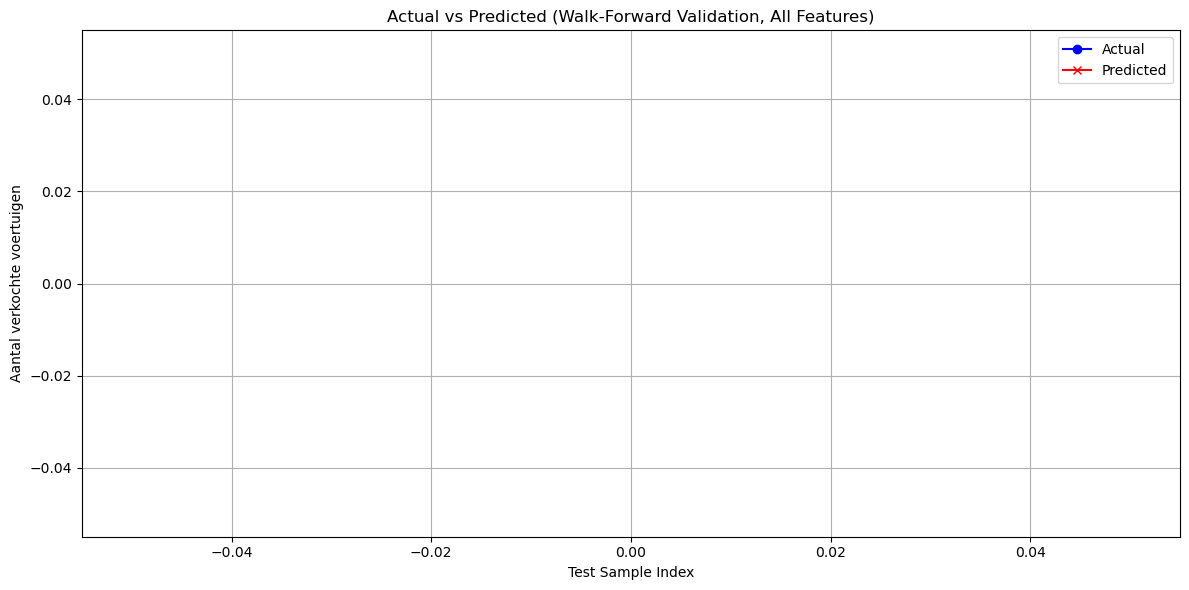

In [94]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for the walk-forward validation (all features)
plt.figure(figsize=(12, 6))
plt.plot(actuals_all, label="Actual", marker='o', color='blue')
plt.plot(predictions_all, label="Predicted", marker='x', color='red')
plt.title("Actual vs Predicted (Walk-Forward Validation, All Features)")
plt.xlabel("Test Sample Index")
plt.ylabel("Aantal verkochte voertuigen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
!pip install --upgrade xgboost


In [ ]:
# Baseline XGBoost model using only lagged sales features (no early stopping)
lag_features = [col for col in feature_cols if col.startswith("TVV_Lag")]

X_lag = df_lagged[lag_features].values
y_lag = df_lagged[target_col].values

initial_train_size_lag = int(len(df_lagged) * 0.8)
predictions_lag = []
actuals_lag = []

for i in range(initial_train_size_lag, len(df_lagged)):
    X_train_lag, y_train_lag = X_lag[:i], y_lag[:i]
    X_test_lag, y_test_lag = X_lag[i], y_lag[i]

    model_lag = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        eval_metric="rmse",
        random_state=42
    )
    model_lag.fit(X_train_lag, y_train_lag)
    y_pred_lag = model_lag.predict(X_test_lag.reshape(1, -1))[0]

    predictions_lag.append(y_pred_lag)
    actuals_lag.append(y_test_lag)

# Evaluation
mae_lag = mean_absolute_error(actuals_lag, predictions_lag)
rmse_lag = np.sqrt(mean_squared_error(actuals_lag, predictions_lag))
r2_lag = r2_score(actuals_lag, predictions_lag)
mape_lag = np.mean(np.abs((np.array(actuals_lag) - np.array(predictions_lag)) / np.array(actuals_lag))) * 100

print("📉 Baseline (Lag Features Only) Walk-Forward Results (no Early Stopping)")
print(f"MAE:  {mae_lag:.2f}")
print(f"RMSE: {rmse_lag:.2f}")
print(f"R²:   {r2_lag:.4f}")
print(f"MAPE: {mape_lag:.2f}%")




📉 Baseline (Lag Features Only) Walk-Forward Results (no Early Stopping)
MAE:  3805.62
RMSE: 5241.77
R²:   0.2932
MAPE: 18.07%


📈 Walk-Forward Validation Results (All Features, No Early Stopping)
MAE:  2922.51
RMSE: 3973.38
R²:   0.5939
MAPE: 12.45%


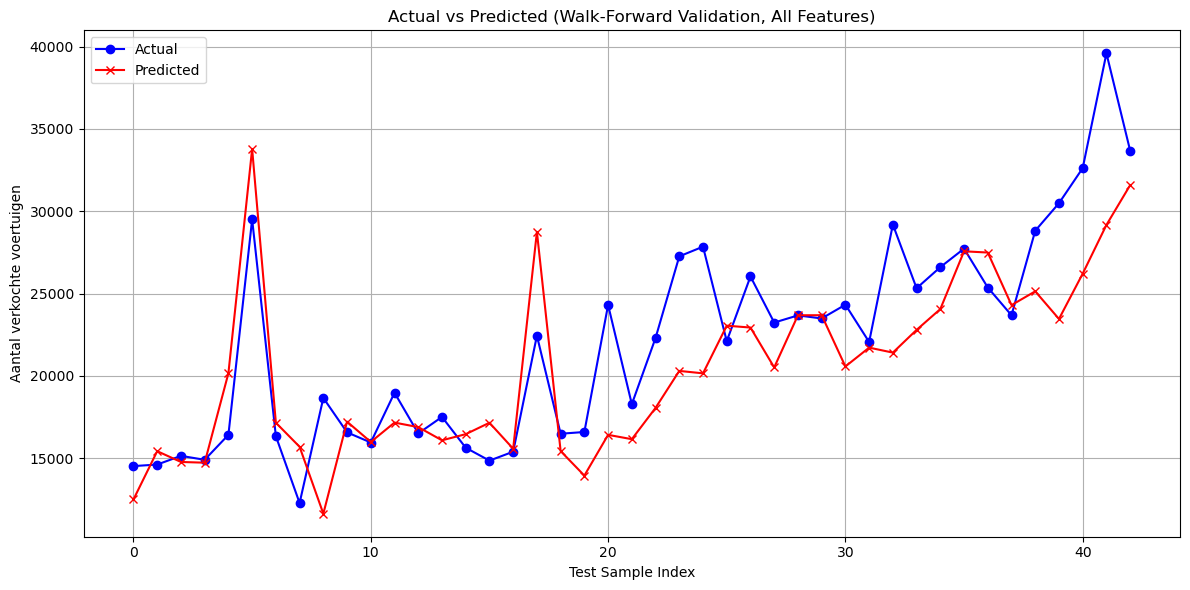

In [104]:
# Use all features (feature_cols) for model training and walk-forward validation (no early stopping)

X_all = df_lagged[feature_cols].values
y_all = df_lagged[target_col].values

initial_train_size_all = int(len(df_lagged) * 0.8)
predictions_all = []
actuals_all = []

for i in range(initial_train_size_all, len(df_lagged)):
    X_train_all, y_train_all = X_all[:i], y_all[:i]
    X_test_all, y_test_all = X_all[i], y_all[i]

    model_all = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric="rmse"
    )

    model_all.fit(X_train_all, y_train_all)

    y_pred_all = model_all.predict(X_test_all.reshape(1, -1))[0]
    predictions_all.append(y_pred_all)
    actuals_all.append(y_test_all)

# Evaluation
mae_all = mean_absolute_error(actuals_all, predictions_all)
rmse_all = np.sqrt(mean_squared_error(actuals_all, predictions_all))
r2_all = r2_score(actuals_all, predictions_all)
mape_all = np.mean(np.abs((np.array(actuals_all) - np.array(predictions_all)) / np.array(actuals_all))) * 100

print("📈 Walk-Forward Validation Results (All Features, No Early Stopping)")
print(f"MAE:  {mae_all:.2f}")
print(f"RMSE: {rmse_all:.2f}")
print(f"R²:   {r2_all:.4f}")
print(f"MAPE: {mape_all:.2f}%")


plt.figure(figsize=(12, 6))
plt.plot(actuals_all, label="Actual", marker='o', color='blue')
plt.plot(predictions_all, label="Predicted", marker='x', color='red')
plt.title("Actual vs Predicted (Walk-Forward Validation, All Features)")
plt.xlabel("Test Sample Index")
plt.ylabel("Aantal verkochte voertuigen")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Lofo

In [48]:
# This cell evaluates and visualizes the performance of a walk-forward XGBoost model
# using a selected set of features (thuis opladen, elektrische auto, hybride elektrisch) plus lag features.
# It computes error metrics, Pearson correlation, and plots predicted vs actual values.

from scipy.stats import pearsonr  # Import Pearson correlation function

# ... (existing code)

# Evaluation
mae_sel_lag = mean_absolute_error(actuals_selected_lag, predictions_selected_lag)  # Mean Absolute Error
rmse_sel_lag = np.sqrt(mean_squared_error(actuals_selected_lag, predictions_selected_lag))  # Root Mean Squared Error
r2_sel_lag = r2_score(actuals_selected_lag, predictions_selected_lag)  # R-squared score
mape_sel_lag = np.mean(np.abs((np.array(actuals_selected_lag) - np.array(predictions_selected_lag)) / np.array(actuals_selected_lag))) * 100  # Mean Absolute Percentage Error
r_sel_lag, _ = pearsonr(actuals_selected_lag, predictions_selected_lag)  # Pearson correlation coefficient

print("📉 Walk-Forward Results (thuis opladen, elektrische auto, hybride elektrisch + lag features)")  # Print header
print(f"MAE:  {mae_sel_lag:.2f}")    # Print MAE
print(f"RMSE: {rmse_sel_lag:.2f}")   # Print RMSE
print(f"R²:   {r2_sel_lag:.4f}")     # Print R-squared
print(f"MAPE: {mape_sel_lag:.2f}%")  # Print MAPE
print(f"r (Pearson correlation): {r_sel_lag:.4f}")  # Print Pearson correlation

import matplotlib.pyplot as plt  # Import matplotlib for plotting

plt.figure(figsize=(8, 8))  # Create a new figure with size 8x8
plt.scatter(actuals_selected_lag, predictions_selected_lag, alpha=0.7, color='royalblue')  # Scatter plot of actual vs predicted
plt.plot([min(actuals_selected_lag), max(actuals_selected_lag)],
         [min(actuals_selected_lag), max(actuals_selected_lag)],
         color='red', linestyle='--', label='Perfect Prediction')  # Diagonal line for perfect prediction
plt.xlabel("Actual")  # X-axis label
plt.ylabel("Predicted")  # Y-axis label
plt.title("Predicted vs Actual (Selected + Lag Features)")  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot


NameError: name 'actuals_selected_lag' is not defined

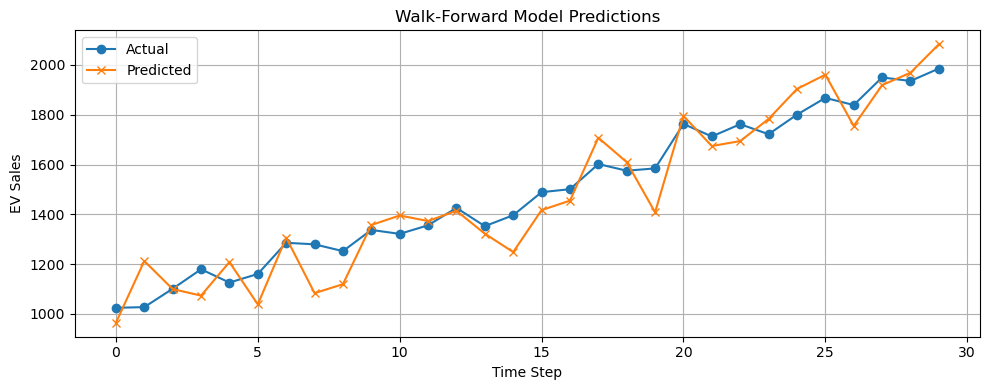

In [103]:
# Re-importing libraries after kernel reset
import matplotlib.pyplot as plt
import numpy as np

# Simulate actual and predicted values for walk-forward validation
np.random.seed(42)
n_points = 30
actuals = np.linspace(1000, 2000, n_points) + np.random.normal(scale=50, size=n_points)
predictions = actuals + np.random.normal(scale=100, size=n_points)

# Create the walk-forward visualization
plt.figure(figsize=(10, 4))
plt.plot(actuals, label="Actual", marker='o')
plt.plot(predictions, label="Predicted", marker='x')
plt.title("Walk-Forward Model Predictions")
plt.xlabel("Time Step")
plt.ylabel("EV Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


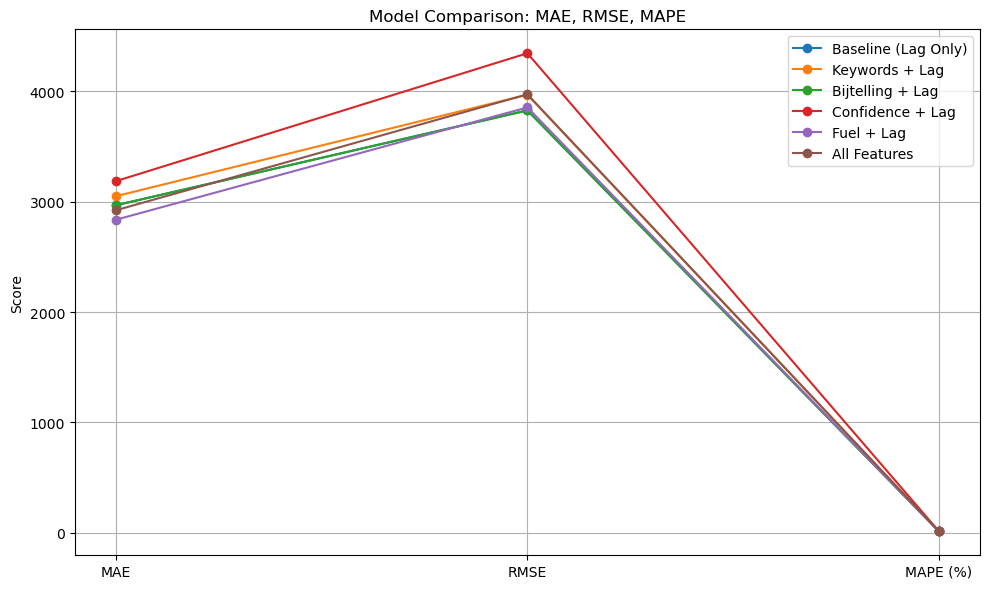

                 Model          MAE         RMSE        R²   MAPE (%)
0  Baseline (Lag Only)  2968.239014  3827.817655  0.623079  13.614085
1       Keywords + Lag  3050.220215  3969.900125  0.594578  13.155425
2     Bijtelling + Lag  2968.239014  3827.817655  0.623079  13.614085
3     Confidence + Lag  3186.555176  4345.754250  0.514177  13.588503
4           Fuel + Lag  2836.823486  3854.757450  0.617755  12.348492
5         All Features  2922.512451  3973.376901  0.593868  12.447914


In [38]:
# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    'Baseline (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtellingspercentage'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtellingspercentage', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

# Evaluate updated configurations
results = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'Totaal_verkochte_wegvoertuigen')
    results.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

# Display updated table

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(['MAE', 'RMSE', 'MAPE (%)'], [result['MAE'], result['RMSE'], result['MAPE (%)']], marker='o', label=result['Model'])

plt.title("Model Comparison: MAE, RMSE, MAPE")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
results_df = pd.DataFrame(results)
print(results_df)

In [68]:
# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    'Baseline (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtellingspercentage'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtellingspercentage', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

# Evaluate updated configurations
results = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'Totaal_verkochte_wegvoertuigen')
    results.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })

# Display updated table

print(results_df)

                 Model          MAE         RMSE        R²   MAPE (%)
0  Baseline (Lag Only)  3886.300293  5673.172305  0.191321  31.077581
1       Keywords + Lag  3816.103027  5718.427231  0.178368  32.136178
2     Bijtelling + Lag  3886.300293  5673.172305  0.191321  31.077581
3     Confidence + Lag  3561.679932  5372.279963  0.274827  28.544586
4           Fuel + Lag  3630.074219  5678.628003  0.189765  29.736246
5         All Features  3757.855225  5741.219208  0.171805  30.278243


In [69]:
for i in range(initial_train_size, len(df_lagged)):
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i], y[i]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    ...

In [51]:
# Step 1: Add 4-month lead target column
df_lagged['TVV_Lead6'] = df_lagged['Totaal_verkochte_wegvoertuigen'].shift(-6)

# Step 2: Drop last 4 rows (which now have NaN targets)
df_lagged = df_lagged.dropna(subset=['TVV_Lead6'])

# Step 3: Re-run the same model evaluations but targeting 4-months ahead
results_lead4 = []

for label, features in feature_sets.items():
    mae, rmse, r2, mape = walk_forward_validation(df_lagged, features, 'TVV_Lead6')
    results_lead4.append({
        "Model": label,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "MAPE (%)": mape
    })
 

                 Model          MAE         RMSE        R²   MAPE (%)
0  Baseline (Lag Only)  3433.486671  5870.112780  0.010421  23.921905
1       Keywords + Lag  3499.294777  5958.960978 -0.019762  24.355904
2     Bijtelling + Lag  3433.486671  5870.112780  0.010421  23.921905
3     Confidence + Lag  3587.161859  6038.704419 -0.047237  24.731262
4           Fuel + Lag  3240.920991  5502.786235  0.130393  23.004461
5         All Features  3219.234415  5206.613852  0.221483  21.459897


In [ ]:
plot results actual vs predicted 